# Parcial 1
Andrés Tamayo
David Plazas

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import ledoit_wolf, MinCovDet, oas
from scipy.linalg import hilbert

%matplotlib inline
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 15})

## Punto 3

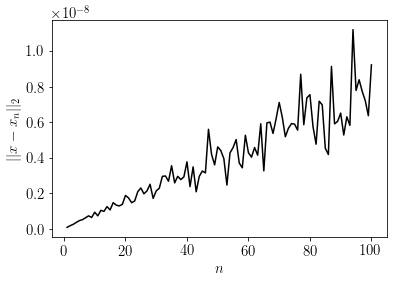

In [24]:
H = hilbert(5)
dists = []
ns = list(range(1, 101))
for n in ns:
    x = n*np.ones((5, 1))
    b = np.matmul(H, x)
    sol = np.matmul(np.linalg.inv(H), b)
    dist = np.linalg.norm(sol - x, ord=2)
    dists.append(dist)

plt.plot(ns, dists, 'k')
plt.xlabel("$n$")
plt.ylabel("$$||x-x_n||_2$$")
plt.savefig("figs/Punto3_og.pdf", bbox_inches='tight')
plt.show()

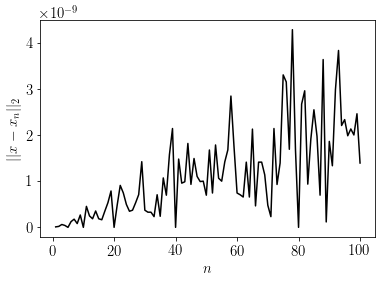

In [25]:
H = hilbert(5)
dists = []
ns = list(range(1, 101))
for n in ns:
    x = n*np.ones((5, 1))
    b = np.matmul(H, x)
    sol = np.matmul(np.linalg.pinv(H), b)
    dist = np.linalg.norm(sol - x, ord=2)
    dists.append(dist)

plt.plot(ns, dists, 'k')
plt.xlabel("$n$")
plt.ylabel("$$||x-x_n||_2$$")
plt.savefig("figs/Punto3_mejorada.pdf", bbox_inches='tight')
plt.show()

## Punto 4

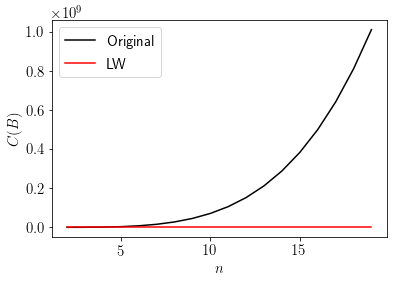

In [40]:
def A(n):
    A = np.array([[1, 2, 3],
                   [2+1/n**2, 4+1/n**2, 6+1/(2*n**2)],
                   [3+1/(n+1), 6+1/(2*n+1), 9+1/(3*n+2)]])
    return A

ns = list(range(2, 20))
conds = []
dets = []
conds_LW = []
dets_LW = []
for n in ns:
    B = np.matmul(A(n).T, A(n))
    conds.append(np.linalg.cond(B))
    dets.append(np.linalg.det(B))
    
    data = np.random.multivariate_normal(np.zeros(3), B, size=1000)
    cov_LW = ledoit_wolf(data)[0]
    conds_LW.append(np.linalg.cond(cov_LW))
    dets_LW.append(np.linalg.det(cov_LW))
    

plt.plot(ns, conds, 'k', label="Original")
plt.plot(ns, conds_LW, 'r', label="LW")
plt.legend()
plt.xlabel("$n$")
plt.ylabel("$C(B)$")
plt.savefig("figs/Punto4_cond.pdf", bbox_inches='tight')
plt.show()

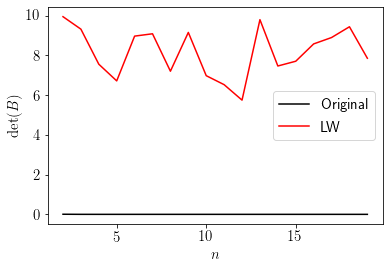

In [41]:
plt.plot(ns, dets, 'k', label="Original")
plt.plot(ns, dets_LW, 'r', label="LW")
plt.legend()
plt.xlabel("$n$")
plt.ylabel("$\mathrm{det}(B)$")
plt.savefig("figs/Punto4_det.pdf", bbox_inches='tight')
plt.show()

## Punto 5

In [82]:
def binary_distances(matrix, means, method=0):
    dists = np.zeros(matrix.shape[1])
    for j in range(matrix.shape[1]):
        a = 0
        b = 0
        c = 0
        d = 0
        for i in range(matrix.shape[0]):
            if matrix[i, j] == 1 and means[i] == 1:
                a += 1
            elif matrix[i, j] == 1 and means[i] == 0:
                b += 1
            elif matrix[i, j] == 0 and means[i] == 1:
                c += 1
            else:
                d += 1
        if method == 0:
            dists[j] = (a*d - b*c) / (np.sqrt((a+c) * (b+d) * (a+b) * (c+d)))
        elif method == 1:
            dists[j] = a / (a + b + c)
        elif method == 2:
            dists[j] = 2*a / (2*a + b + c)
    return dists

In [83]:
# Read file
file = open("portfolio100.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data.append(row)
    
# Prepare data
data_port = np.array(data, dtype=np.float)
last_col = data_port[:, -1]
data_port = data_port[:, :-1]

<ipython-input-82-2942d933c907>:18: RuntimeWarning: invalid value encountered in double_scalars
  dists[j] = (a*d - b*c) / (np.sqrt((a+c) * (b+d) * (a+b) * (c+d)))


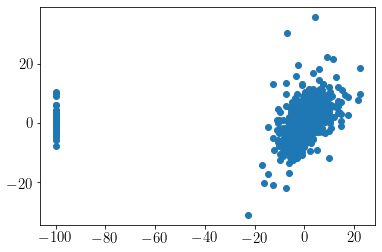

In [126]:
binary_matrix = np.zeros(data_port.shape)
binary_matrix[data_port > 0] = 1

binary_col = np.zeros(last_col.shape)
binary_col[last_col > 0] = 1

dists = binary_distances(binary_matrix, binary_col)
indexes = dists.argsort()[0:2]
data = data_port[:, indexes]

In [140]:
def mahal(data, y, IV):
    diff = data - y
    return np.sqrt((np.matmul(diff, IV) * diff).sum(-1))

def remove_outliers(dataset, cov):
    mean = np.mean(dataset, axis = 0).reshape((1, cov.shape[0]))
    distances = mahal(dataset, mean, np.linalg.inv(cov))
    perc_90 = np.percentile(distances, 90)

    # Data separation
    data = dataset[distances <= perc_90, :]
    outliers = dataset[distances > perc_90, :]
    
    return data, outliers

In [141]:
covs = []
covs.append(np.linalg.inv(np.cov(data.T)))
covs.append(np.linalg.inv(ledoit_wolf(data)[0]))
covs.append(np.linalg.inv(MinCovDet().fit(data).covariance_))
covs.append(np.linalg.inv(oas(data)[0]))

In [142]:
names = ['habitual', 'lw', 'mcd', 'oas']
j = 0
for cov in covs:
    data_cut, outliers = remove_outliers(data, cov)
    plt.scatter(data_cut[:, 0], data_cut[:, 1], color='k', s=4)
    plt.scatter(outliers[:, 0], outliers[:, 1], color='r', s=4)
    plt.savefig('figs/outliers_'+names[j]+'.pdf')
    plt.clf()
    j += 1

<Figure size 432x288 with 0 Axes>